In this notebook we sketch the implementation of [Artemis](https://arxiv.org/pdf/2006.14591.pdf). In artemis, every device keeps a memory variable $h_{i}$ to track the gradient in order to insure the convergence, and exchanges the compressed version of the difference between the gradient and this value with the server.

In [1]:
import sys; sys.path.insert(0, '../..')

%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from tqdm import tqdm

from src.utils.Constants import NB_EPOCH, NB_RUN, DEVICE_TYPE, LR, BATCH_SIZE, NB_WORKERS
from src.utils.Utilities import pickle_loader, pickle_saver
from src.deeplearning.Compression import QuantizationCompressor
from src.deeplearning.Artemis import Artemis
from src.deeplearning.Utilities import multiple_run_descent, ResultsOfSeveralDescents
from src.deeplearning.Parameters import Parameters


filename = "mnist"

# Compression 


We first need to implement a compression scheme, in this example we use quantization

In [2]:
compressor = QuantizationCompressor()

# Dataset

We simply use iid MNIST here, can be changed with any dataset later, Note that you only need to specify a list of `torch.utils.data.DataLoaders`, each of them is a loader of the dataset of a given client.


In [3]:
trans = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (1.0,))
                                 ])

# TODO : To test, not sure what it does exactly.
dataset = Subset(MNIST(root="./data", download=True, transform=trans), range(300))

loaders = []
for _ in range(NB_WORKERS):
    loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)
    loaders.append(loader)


# Learner

We also implement a `Learner` class that will be used to train and evaluate a deep-learning model

# Models

We use a two layer neural network, can be replaced with whatever is needed.

## Artemis


This is the core class of this project 

Computing the best approximation of the model.

In [4]:
%%time
artemis = Artemis(loaders, compressor, variant=0)
for round_idx in range(10):
    artemis.step()
print("---> final loss:", artemis.losses[-1])
obj_min = artemis.losses[-1]
pickle_saver(obj_min, filename + "-obj_min")

---> final loss: 11.539461898803712
CPU times: user 15.2 s, sys: 17.8 s, total: 33 s
Wall time: 6.14 s


In [5]:
%%time
all_descent = {}
for type_params in tqdm(["SGD", "Artemis"]):
    multiple_sg_descent = multiple_run_descent(Parameters(), loaders)
    all_descent[type_params] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, NB_WORKERS)
pickle_saver(res, filename + "-descent")

  0%|          | 0/2 [00:00<?, ?it/s]

---> final loss: 11.549653029441833


 50%|█████     | 1/2 [00:04<00:04,  4.08s/it]

---> final loss: 11.549653029441833
---> final loss: 11.549653029441833


100%|██████████| 2/2 [00:08<00:00,  4.01s/it]

---> final loss: 11.549653029441833
CPU times: user 20.1 s, sys: 22.5 s, total: 42.6 s
Wall time: 8.03 s


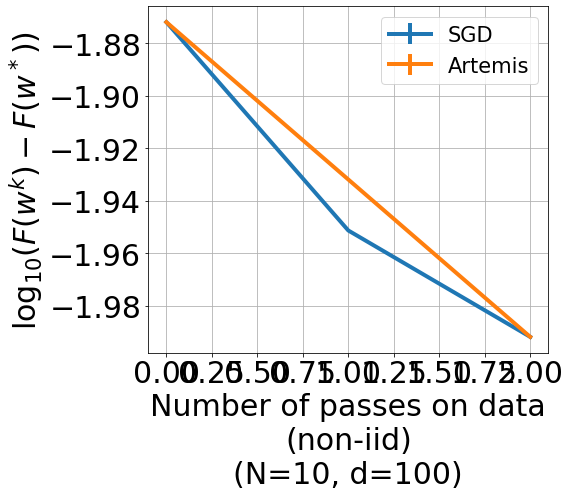

In [6]:
from src.utils.ErrorPlotter import *
obj_min = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")


plot_error_dist(res.get_loss(obj_min), res.names, res.nb_devices_for_the_run, 100,
                all_error=res.get_std(obj_min), x_legend="Number of passes on data\n(non-iid)") 

# TODO tasks

* Complete the #TODO tasks left inside the code
* Use only one learner instead of a list of learners for memory efficiency
* Check if the compression class is working (I copied it directly from choco-SGD repo without any tests)
* Test the evolution of the parameters on a "toy example", for example linear regression.